In [1]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/BM_8051_Carpinus_betulus.tif.zip'
extract_dir = '/content/pollen_image'

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

Mounted at /content/drive


In [2]:
import os

# Check the contents of the extracted directory
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        print(os.path.join(root, file))

/content/pollen_image/BM_8051_Carpinus_betulus.tif
/content/pollen_image/__MACOSX/._BM_8051_Carpinus_betulus.tif


In [3]:
import tifffile as tiff
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Physical calibration: microns per pixel (estimate)
um_per_pixel = 0.18

# parameters to get ≥36 tiles with enough context
tile_size_um = 1200   # μm
overlap_um   = 600    # μm

# Convert microns to pixels (integer)
tile_size_px = int(tile_size_um / um_per_pixel)
overlap_px   = int(overlap_um   / um_per_pixel)

print(f"Tile size: {tile_size_um} μm → {tile_size_px} px")
print(f"Overlap:   {overlap_um} μm → {overlap_px} px")

Tile size: 1200 μm → 6666 px
Overlap:   600 μm → 3333 px


In [4]:
# Base output directory and subfolders
output_base   = '/content/pollen_image_crops'
color_dir     = os.path.join(output_base, 'color')
gray_dir      = os.path.join(output_base, 'grayscale')
norm_dir      = os.path.join(output_base, 'grayscale_equalized')

# Create directories if missing
for d in (color_dir, gray_dir, norm_dir):
    os.makedirs(d, exist_ok=True)

print("Created output directories:")
print(" ├", color_dir)
print(" ├", gray_dir)
print(" └", norm_dir)

Created output directories:
 ├ /content/pollen_image_crops/color
 ├ /content/pollen_image_crops/grayscale
 └ /content/pollen_image_crops/grayscale_equalized


In [5]:
# Path to extracted TIFF
tif_path = '/content/pollen_image/BM_8051_Carpinus_betulus.tif'
slide_name = os.path.basename(tif_path)

# Load first page of TIFF into NumPy array
with tiff.TiffFile(tif_path) as tif:
    full_img = tif.pages[0].asarray()

# Get image dimensions (height, width)
img_h, img_w = full_img.shape[:2]
print(f"Loaded slide '{slide_name}' with resolution: {img_w} × {img_h} px")

Loaded slide 'BM_8051_Carpinus_betulus.tif' with resolution: 28148 × 29198 px


In [6]:
# Compute step size and grid positions
step = tile_size_px - overlap_px
x_steps = range(0, img_w, step)
y_steps = range(0, img_h, step)

# Count how many full-size tiles fit
full_tiles = sum(
    1
    for y in y_steps
    for x in x_steps
    if (x + tile_size_px) <= img_w and (y + tile_size_px) <= img_h
)

print(f"Full tiles to generate: {full_tiles}")

Full tiles to generate: 49


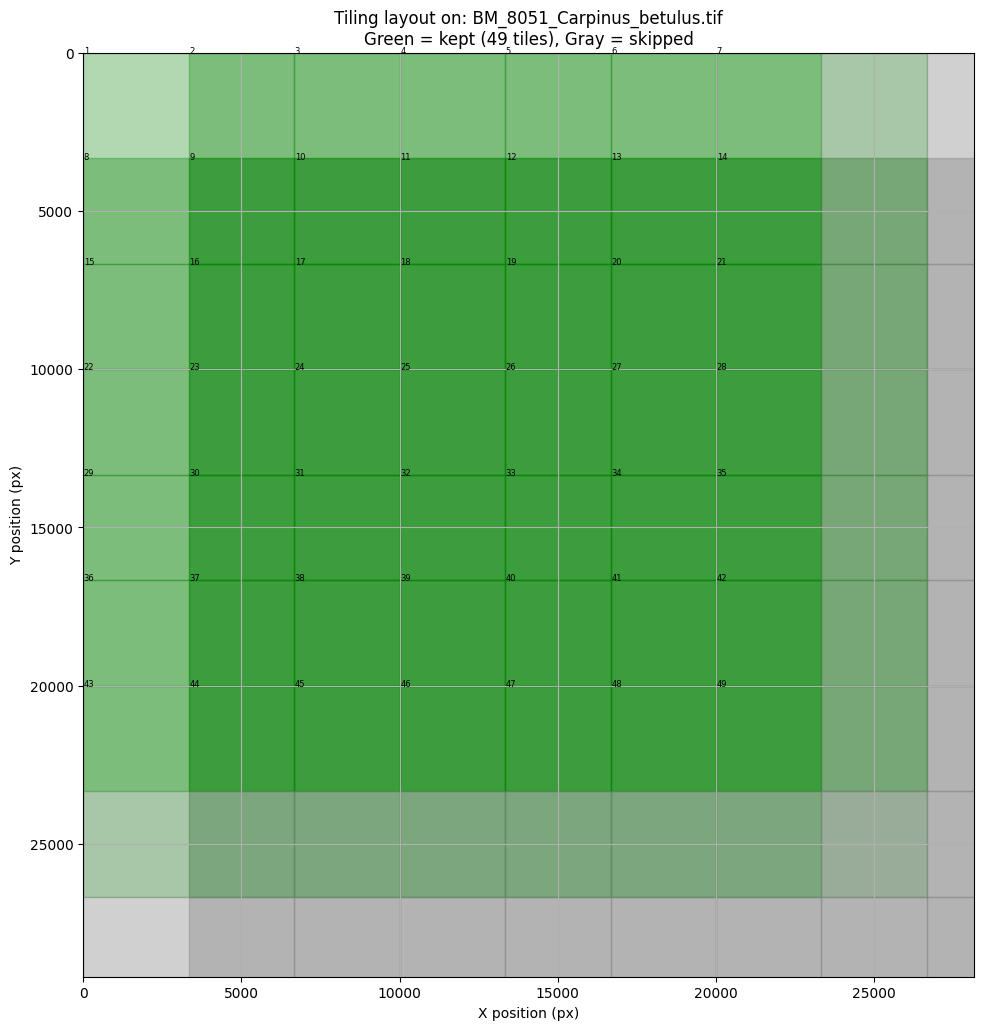

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tifffile as tiff
import os

# Plotting
fig, ax = plt.subplots(figsize=(16, 12))
tile_num = 1

for y in y_steps:
    for x in x_steps:
        if (x + tile_size_px <= img_w) and (y + tile_size_px <= img_h):
            # Valid tile (green)
            rect = patches.Rectangle((x, y), tile_size_px, tile_size_px,
                                     linewidth=1, edgecolor='green', facecolor='green', alpha=0.3)
            ax.add_patch(rect)
            ax.text(x + 20, y + 20, str(tile_num), fontsize=6, color='black')
            tile_num += 1
        else:
            # Overflow (gray)
            rect = patches.Rectangle((x, y), tile_size_px, tile_size_px,
                                     linewidth=1, edgecolor='gray', facecolor='gray', alpha=0.2)
            ax.add_patch(rect)

# Add image boundary
ax.set_xlim([0, img_w])
ax.set_ylim([0, img_h])
ax.invert_yaxis()
ax.set_aspect('equal')
plt.title(f"Tiling layout on: {os.path.basename(tif_path)}\nGreen = kept ({tile_num - 1} tiles), Gray = skipped")
plt.xlabel("X position (px)")
plt.ylabel("Y position (px)")
plt.grid(True)
plt.show()

Tile 01: x_start=0, y_start=0, crop_shape=(6666,6666), expected=(6666,6666)


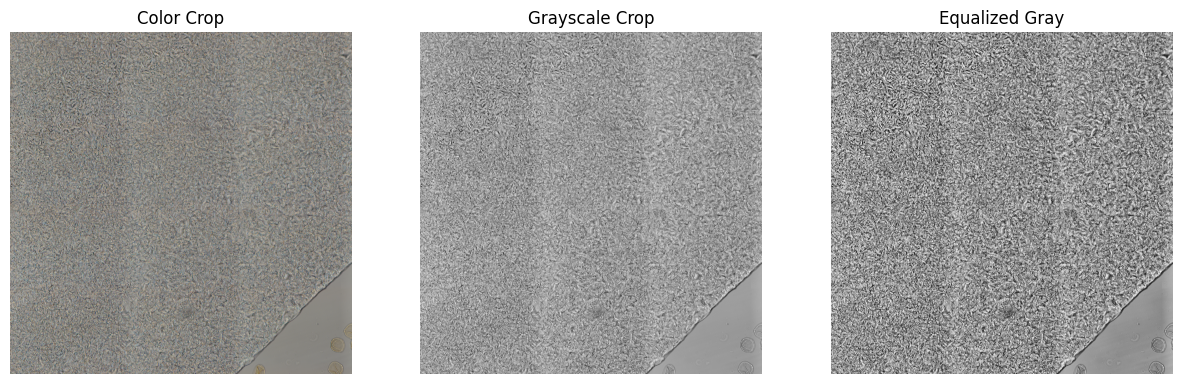

Tile 02: x_start=3333, y_start=0, crop_shape=(6666,6666), expected=(6666,6666)
Tile 03: x_start=6666, y_start=0, crop_shape=(6666,6666), expected=(6666,6666)
Tile 04: x_start=9999, y_start=0, crop_shape=(6666,6666), expected=(6666,6666)
Tile 05: x_start=13332, y_start=0, crop_shape=(6666,6666), expected=(6666,6666)
Tile 06: x_start=16665, y_start=0, crop_shape=(6666,6666), expected=(6666,6666)
Tile 07: x_start=19998, y_start=0, crop_shape=(6666,6666), expected=(6666,6666)
Skipping out-of-bounds tile at x=23331, y=0
Skipping out-of-bounds tile at x=26664, y=0
Tile 08: x_start=0, y_start=3333, crop_shape=(6666,6666), expected=(6666,6666)
Tile 09: x_start=3333, y_start=3333, crop_shape=(6666,6666), expected=(6666,6666)
Tile 10: x_start=6666, y_start=3333, crop_shape=(6666,6666), expected=(6666,6666)
Tile 11: x_start=9999, y_start=3333, crop_shape=(6666,6666), expected=(6666,6666)
Tile 12: x_start=13332, y_start=3333, crop_shape=(6666,6666), expected=(6666,6666)
Tile 13: x_start=16665, y_s

In [8]:
import cv2

# Tile cropping loop with shape checks
metadata = []
total = 0

for y in y_steps:
    for x in x_steps:
        x_end = x + tile_size_px
        y_end = y + tile_size_px
        # Skip any tile that would exceed image bounds
        if x_end > img_w or y_end > img_h:
            print(f"Skipping out-of-bounds tile at x={x}, y={y}")
            continue

        # Crop the color image region
        crop = full_img[y:y_end, x:x_end]

        # --- Shape check ---
        h, w = crop.shape[:2]
        print(f"Tile {total+1:02d}: x_start={x}, y_start={y}, crop_shape=({h},{w}), expected=({tile_size_px},{tile_size_px})")
        if h != tile_size_px or w != tile_size_px:
            print(f"Size mismatch on tile {total+1}: got ({h},{w})")

        # Convert to PIL Image for saving
        img_color = Image.fromarray(crop)
        fname_base = f"crop_y{y}_{y_end}_x{x}_{x_end}.png"

        # Save the color crop
        img_color.save(os.path.join(color_dir, fname_base))

        # Convert to grayscale and save
        img_gray = img_color.convert('L')
        fname_gray = fname_base.replace('.png', '_gray.png')
        img_gray.save(os.path.join(gray_dir, fname_gray))

        # Apply CLAHE histogram equalization using OpenCV
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(16, 16))
        gray_np = np.array(img_gray)
        eq_np = clahe.apply(gray_np)
        img_eq = Image.fromarray(eq_np)

        # Save CLAHE-equalized version
        fname_eq = fname_base.replace('.png', '_gray_eq.png')
        img_eq.save(os.path.join(norm_dir, fname_eq))

        # Record metadata for this tile
        metadata.append({
            "slide_name":    slide_name,
            "x_start":       x,
            "y_start":       y,
            "x_end":         x_end,
            "y_end":         y_end,
            "file_color":    os.path.join('color', fname_base),
            "file_gray":     os.path.join('grayscale', fname_gray),
            "file_gray_eq":  os.path.join('grayscale_equalized', fname_eq),
            "tile_size_um":  tile_size_um,
            "overlap_um":    overlap_um
        })

        total += 1

        # Show preview of first tile (color, gray, equalized)
        if total == 1:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(crop)
            axs[0].set_title('Color Crop');       axs[0].axis('off')
            axs[1].imshow(np.array(img_gray), cmap='gray')
            axs[1].set_title('Grayscale Crop');   axs[1].axis('off')
            axs[2].imshow(np.array(img_eq), cmap='gray')
            axs[2].set_title('Equalized Gray');   axs[2].axis('off')
            plt.show()

print(f"Saved {total} tiles (color + gray + normalized).")

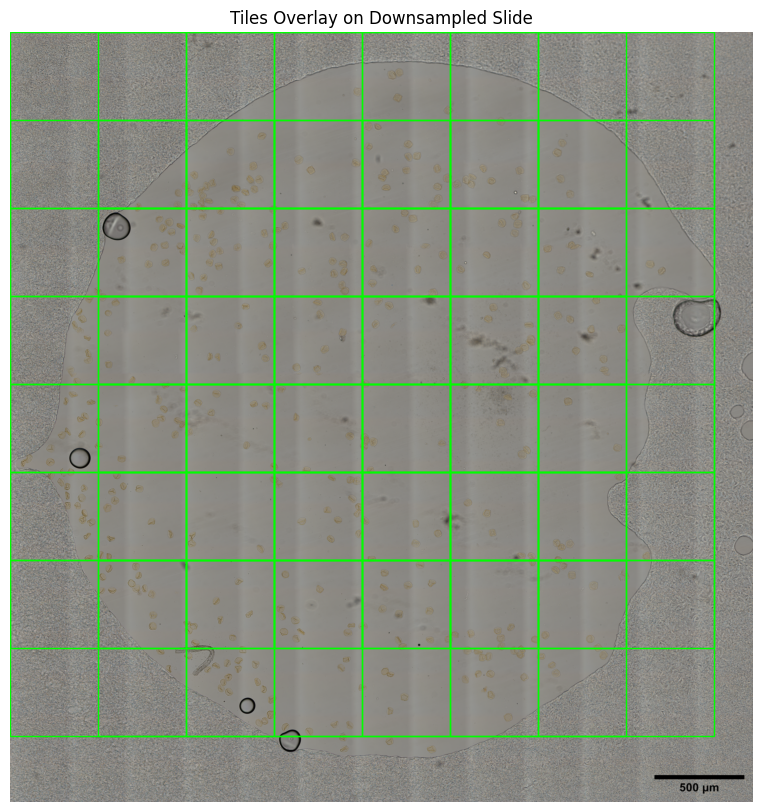

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# downsample factor for speed & fitting on screen
downsample = 0.05
# create a small preview of the whole slide
preview = Image.fromarray(full_img).resize(
    (int(img_w * downsample), int(img_h * downsample))
)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(preview)
ax.axis('off')
ax.set_title('Tiles Overlay on Downsampled Slide')

# draw each tile rectangle
for tile in metadata:
    x0 = tile['x_start'] * downsample
    y0 = tile['y_start'] * downsample
    w0 = tile_size_px  * downsample
    h0 = tile_size_px  * downsample
    rect = Rectangle((x0, y0), w0, h0,
                     edgecolor='lime', facecolor='none', linewidth=1)
    ax.add_patch(rect)

plt.show()

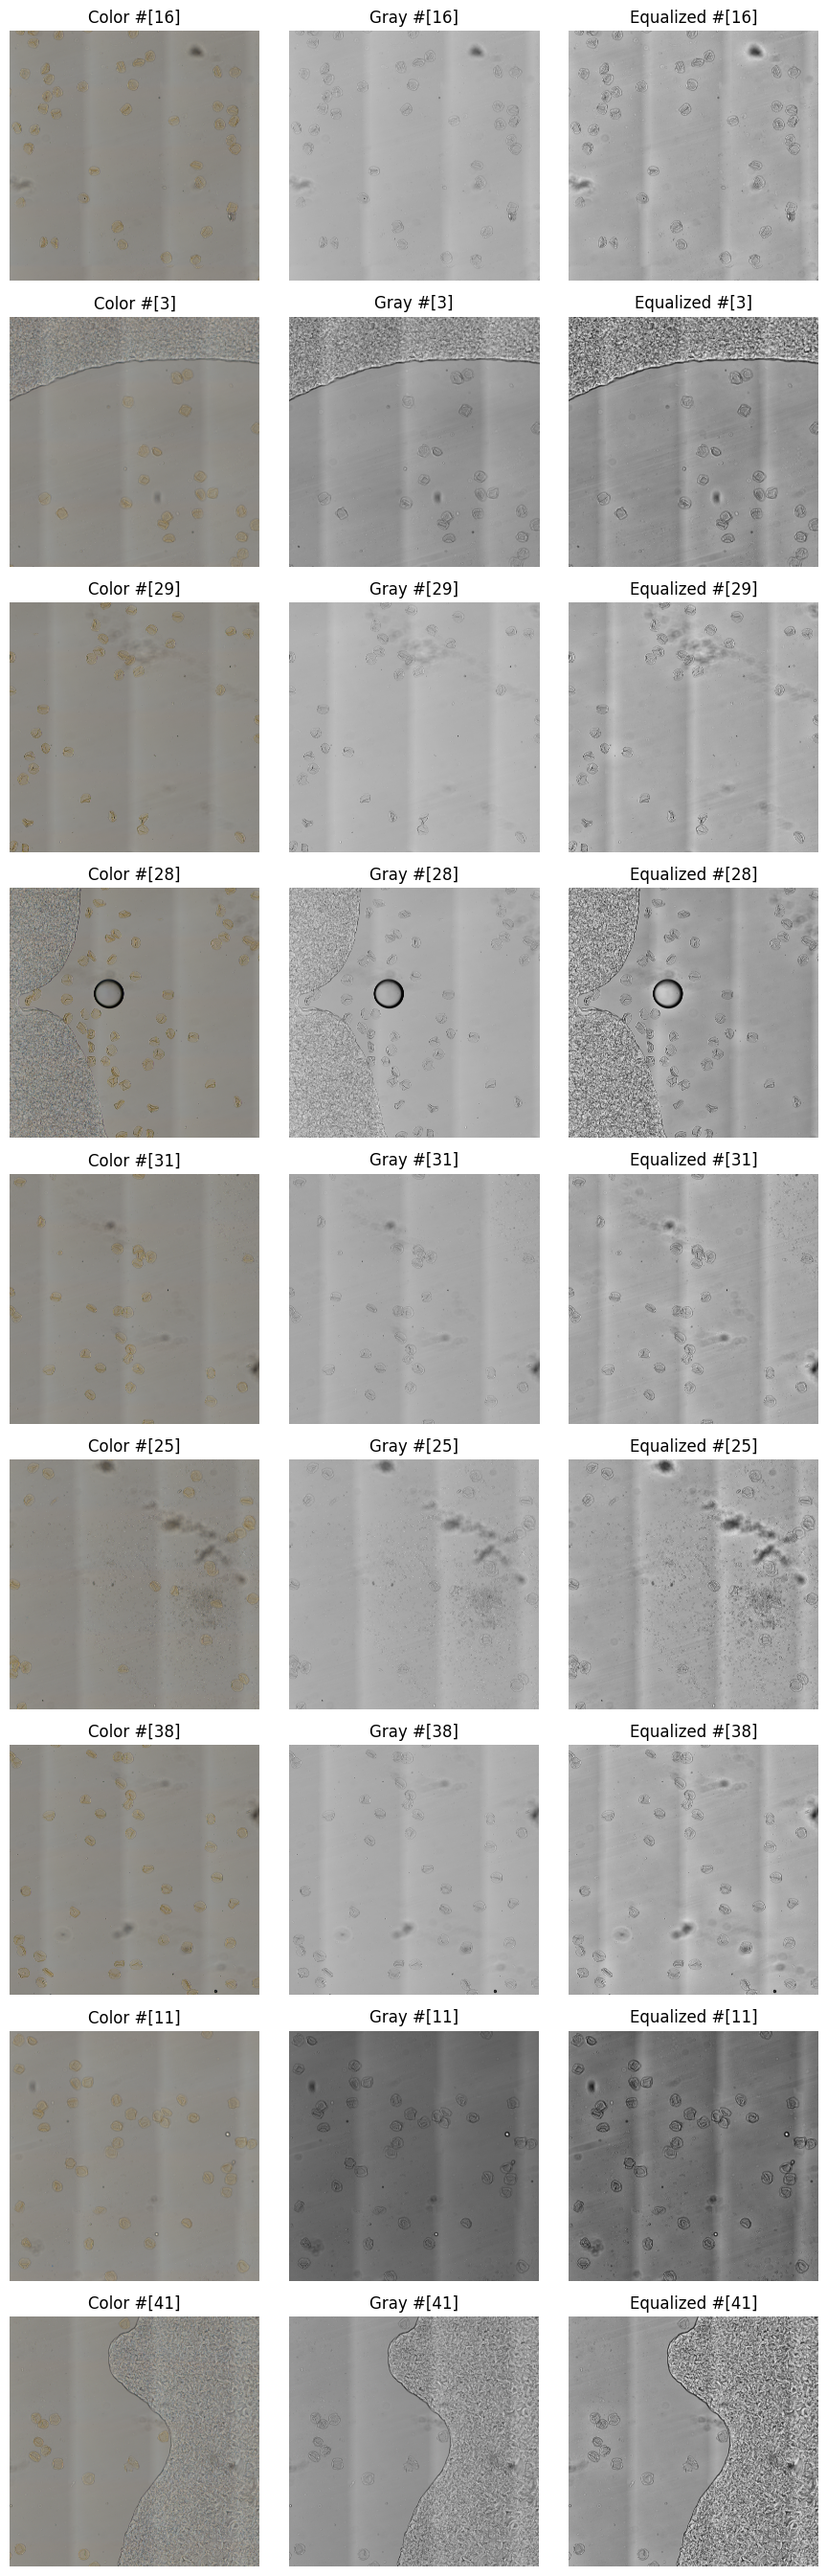

In [10]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

n_samples = 9
sample_idxs = random.sample(range(len(metadata)), n_samples)

fig, axs = plt.subplots(n_samples, 3, figsize=(9, 3 * n_samples))
for row, idx in enumerate(sample_idxs):
    tile = metadata[idx]
    paths = [
        os.path.join(output_base, tile['file_color']),
        os.path.join(output_base, tile['file_gray']),
        os.path.join(output_base, tile['file_gray_eq']),
    ]
    titles = ['Color', 'Gray', 'Equalized']
    for col, (p, t) in enumerate(zip(paths, titles)):
        img = Image.open(p)
        axs[row, col].imshow(img, cmap='gray' if col>0 else None)
        axs[row, col].set_title(f"{t} #[{idx}]")
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

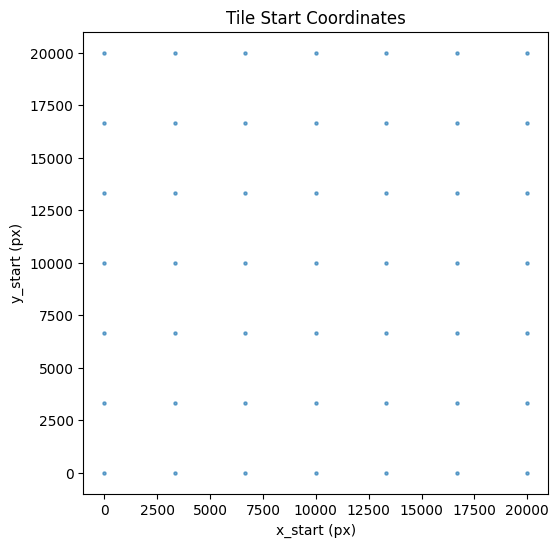

In [11]:
import matplotlib.pyplot as plt

# extract all x_start, y_start
xs = [t['x_start'] for t in metadata]
ys = [t['y_start'] for t in metadata]

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xs, ys, s=5, alpha=0.6)
ax.set_title('Tile Start Coordinates')
ax.set_xlabel('x_start (px)')
ax.set_ylabel('y_start (px)')
plt.show()

In [12]:
# Convert metadata list to DataFrame and save as CSV
metadata_df = pd.DataFrame(metadata)
csv_path = '/content/tile_metadata.csv'
metadata_df.to_csv(csv_path, index=False)

print(f"Metadata CSV saved to: {csv_path}")

metadata_df.head()

Metadata CSV saved to: /content/tile_metadata.csv


slide_name  x_start  y_start  x_end  y_end  \
0  BM_8051_Carpinus_betulus.tif        0        0   6666   6666   
1  BM_8051_Carpinus_betulus.tif     3333        0   9999   6666   
2  BM_8051_Carpinus_betulus.tif     6666        0  13332   6666   
3  BM_8051_Carpinus_betulus.tif     9999        0  16665   6666   
4  BM_8051_Carpinus_betulus.tif    13332        0  19998   6666   

                            file_color  \
0       color/crop_y0_6666_x0_6666.png   
1    color/crop_y0_6666_x3333_9999.png   
2   color/crop_y0_6666_x6666_13332.png   
3   color/crop_y0_6666_x9999_16665.png   
4  color/crop_y0_6666_x13332_19998.png   

                                      file_gray  \
0       grayscale/crop_y0_6666_x0_6666_gray.png   
1    grayscale/crop_y0_6666_x3333_9999_gray.png   
2   grayscale/crop_y0_6666_x6666_13332_gray.png   
3   grayscale/crop_y0_6666_x9999_16665_gray.png   
4  grayscale/crop_y0_6666_x13332_19998_gray.png   

                                        file_gray_eq  tile_size_um  overlap_um  
0  grayscale_equalized/crop_y0_6666_x0_6666_gray_...          1200         600  
1  grayscale_equalized/crop_y0_6666_x3333_9999_gr...          1200         600  
2  grayscale_equalized/crop_y0_6666_x6666_13332_g...          1200         600  
3  grayscale_equalized/crop_y0_6666_x9999_16665_g...          1200         600  
4  grayscale_equalized/crop_y0_6666_x13332_19998_...          1200         600

In [13]:
# Zip up grayscale crops
import shutil

gray_zip_base = '/content/grayscale_crops'
shutil.make_archive(gray_zip_base, 'zip', gray_dir)
print(f"Grayscale crops zipped to: {gray_zip_base}.zip")

eq_zip_base = '/content/equalized_grayscale_crops'
shutil.make_archive(eq_zip_base, 'zip', norm_dir)
print(f"Equalized grayscale crops zipped to: {eq_zip_base}.zip")

Grayscale crops zipped to: /content/grayscale_crops.zip
Equalized grayscale crops zipped to: /content/equalized_grayscale_crops.zip


In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

In [66]:
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer

import os
import cv2
import random
import matplotlib.pyplot as plt

# Define paths
train_img_dir = "/content/images_train"
val_img_dir   = "/content/images_val"
train_ann_file = "/content/labels_pollen_annotation.json"
val_ann_file   = "/content/labels_val.json"

In [67]:
# Register datasets
register_coco_instances("pollen_train", {}, train_ann_file, train_img_dir)
register_coco_instances("pollen_val", {}, val_ann_file, val_img_dir)

[05/19 17:46:24 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/labels_pollen_annotation.json


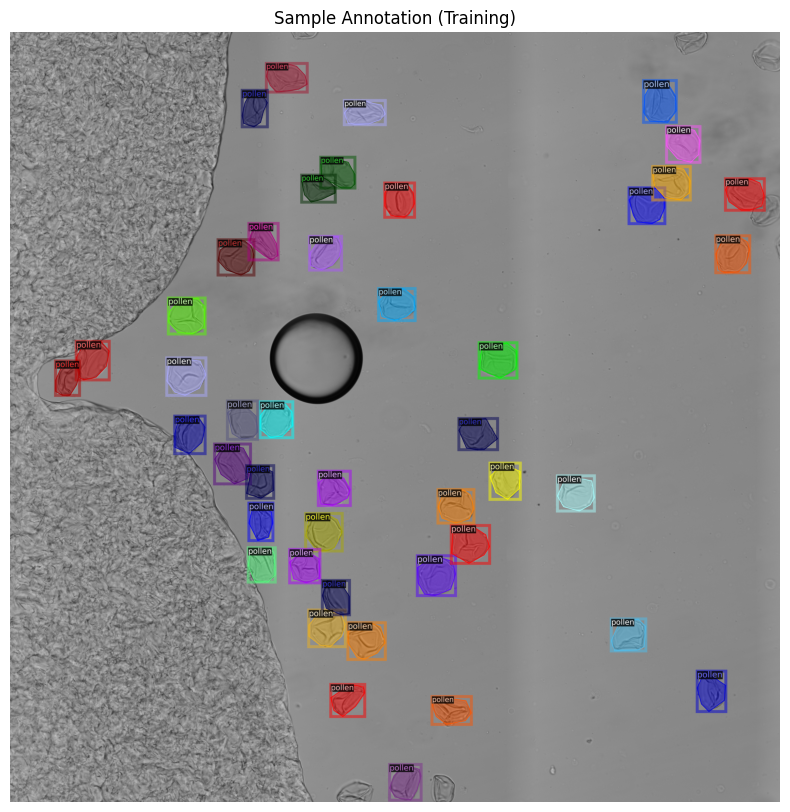

In [68]:
# Visualize a sample from training set
metadata = MetadataCatalog.get("pollen_train")
dataset_dicts = DatasetCatalog.get("pollen_train")
sample = random.choice(dataset_dicts)
img_path = os.path.join(train_img_dir, sample["file_name"])
img = cv2.imread(img_path)

visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
out = visualizer.draw_dataset_dict(sample)

plt.figure(figsize=(10, 10))
plt.imshow(out.get_image())
plt.axis('off')
plt.title("Sample Annotation (Training)")
plt.show()

[05/19 17:46:35 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/labels_val.json


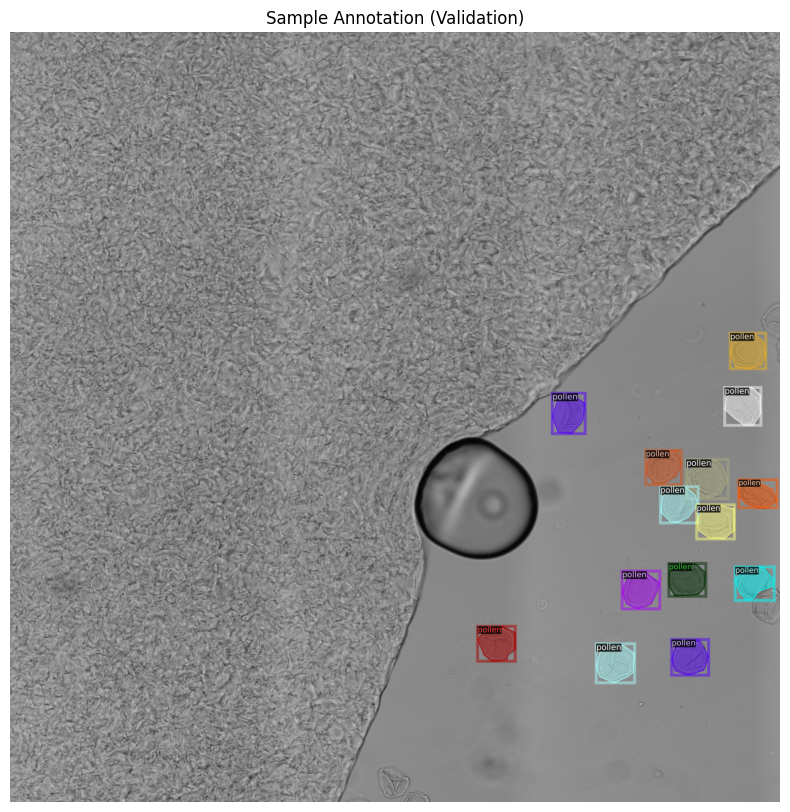

In [69]:
# Visualize a sample from validation set
val_metadata = MetadataCatalog.get("pollen_val")
val_dataset_dicts = DatasetCatalog.get("pollen_val")

# Pick a image
val_sample = random.choice(val_dataset_dicts)
val_img_path = os.path.join(val_img_dir, val_sample["file_name"])
val_img = cv2.imread(val_img_path)

# Visualize
val_visualizer = Visualizer(val_img[:, :, ::-1], metadata=val_metadata, scale=1.0)
val_out = val_visualizer.draw_dataset_dict(val_sample)

plt.figure(figsize=(10, 10))
plt.imshow(val_out.get_image())
plt.axis('off')
plt.title("Sample Annotation (Validation)")
plt.show()

In [70]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()

# Load base config for Mask R-CNN
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))

# Dataset registration names
cfg.DATASETS.TRAIN = ("pollen_train",)
cfg.DATASETS.TEST  = ("pollen_val",)

# Number of classes (only 'pollen')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Batch and data loader
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2

# Learning rate & steps
cfg.SOLVER.BASE_LR = 0.0005
cfg.SOLVER.MAX_ITER = 100
cfg.SOLVER.STEPS = []        # no step decay

# RoI head
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # balanced with IMS_PER_BATCH

# Confidence threshold for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Output directory
cfg.OUTPUT_DIR = "/content/output_pollen"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Pretrained COCO weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)

In [71]:
# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/19 17:49:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[05/19 17:49:04 d2.engine.train_loop]: Starting training from iteration 0
[05/19 17:49:47 d2.utils.events]:  eta: 0:02:48  iter: 19  total_loss: 2.231  loss_cls: 0.6739  loss_box_reg: 0.6855  loss_mask: 0.6748  loss_rpn_cls: 0.09817  loss_rpn_loc: 0.07162    time: 2.1024  last_time: 2.0687  data_time: 1.9813  last_data_time: 1.9435   lr: 9.5405e-05  max_mem: 12886M
[05/19 17:50:29 d2.utils.events]:  eta: 0:02:05  iter: 39  total_loss: 1.729  loss_cls: 0.4133  loss_box_reg: 0.7135  loss_mask: 0.4579  loss_rpn_cls: 0.03092  loss_rpn_loc: 0.0676    time: 2.0992  last_time: 2.0885  data_time: 1.9506  last_data_time: 1.9493   lr: 0.00019531  max_mem: 12886M
[05/19 17:51:11 d2.utils.events]:  eta: 0:01:23  iter: 59  total_loss: 1.137  loss_cls: 0.2463  loss_box_reg: 0.5711  loss_mask: 0.2373  loss_rpn_cls: 0.01509  loss_rpn_loc: 0.06501    time: 2.0985  last_time: 2.0928  data_time: 1.9550  last_data_time: 1.9331   lr: 0.0002952  max_mem: 12886M
[05/19 17:51:53 d2.utils.events]:  eta: 0:00:4

In [74]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("pollen_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "pollen_val")
results = inference_on_dataset(trainer.model, val_loader, evaluator)
print(results)

WARNING [05/19 17:55:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/19 17:55:14 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/labels_val.json
[05/19 17:55:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/19 17:55:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/19 17:55:14 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[05/19 17:55:14 d2.data.common]: Serialized dataset takes 0.00 MiB
[05/19 17:55:14 d2.evaluation.evaluator]: Start inference on 1 batches
[05/19 17:55:19 d2.evaluation.evaluator]: Inference done 1/1. Dataloading: 0.0000 s/iter. Inference: 0.2131 s/iter. Eval: 2.0656 s/iter. Total: 2.2787 s/iter. ETA=0:00:00
[05/19 17:55:19 d2.e

[05/19 17:55:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output_pollen/model_final.pth ...


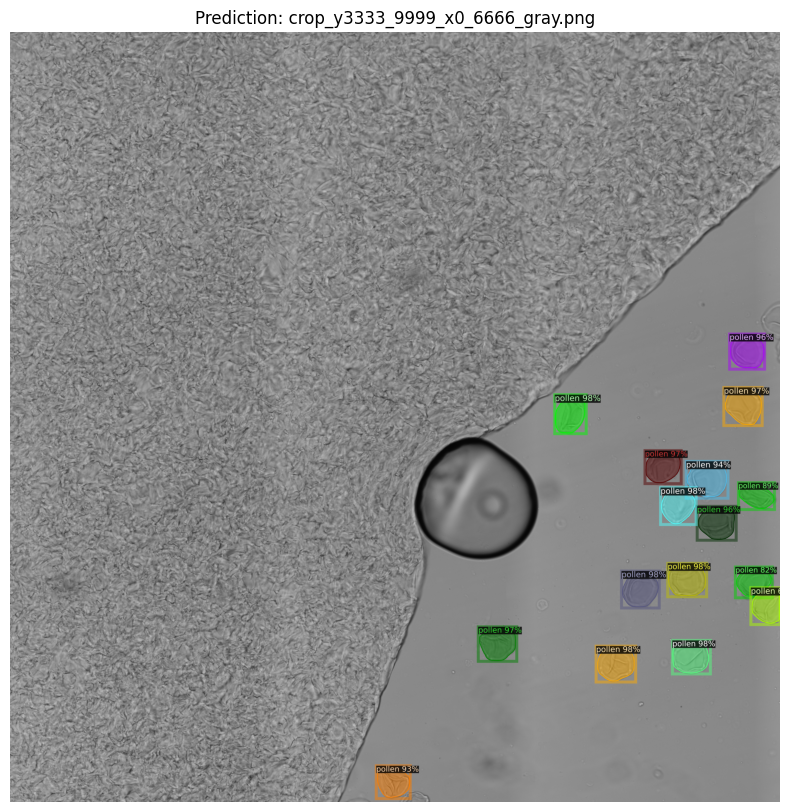

In [75]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
import cv2, os, matplotlib.pyplot as plt

predictor = DefaultPredictor(cfg)

val_images = [
    "/content/images_val/crop_y3333_9999_x0_6666_gray.png",
]

for path in val_images:
    img = cv2.imread(path)
    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get("pollen_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image())
    plt.axis('off')
    plt.title(f"Prediction: {os.path.basename(path)}")
    plt.show()

[05/19 17:59:53 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/labels_val.json


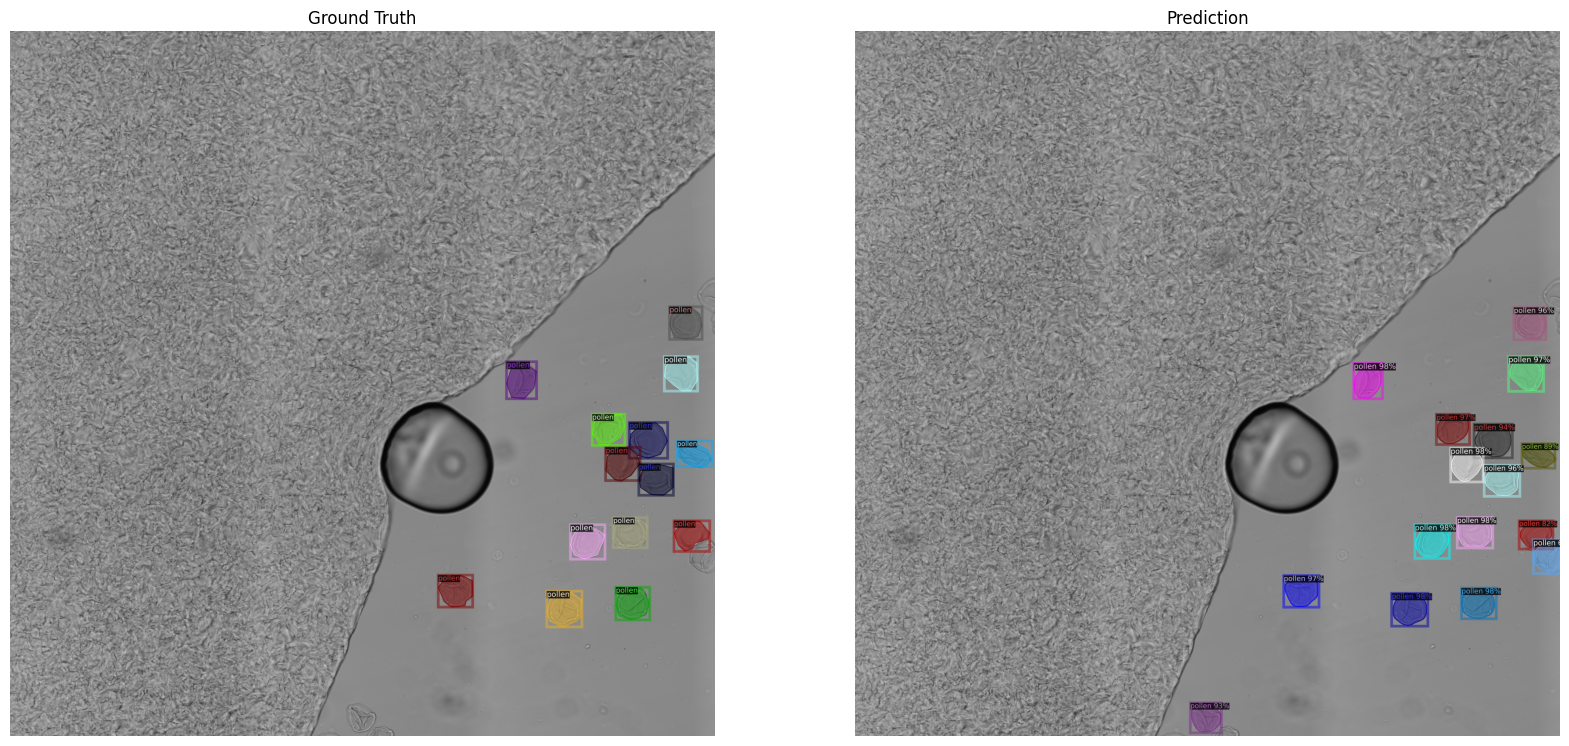

In [77]:
# Ground truth
v_gt = Visualizer(img[:, :, ::-1], MetadataCatalog.get("pollen_val"), scale=1.2)
out_gt = v_gt.draw_dataset_dict(DatasetCatalog.get("pollen_val")[0])

# prediction
v_pred = Visualizer(img[:, :, ::-1], MetadataCatalog.get("pollen_val"), scale=1.2)
out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))

# Visualise
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(out_gt.get_image())
axs[0].set_title("Ground Truth"); axs[0].axis("off")
axs[1].imshow(out_pred.get_image())
axs[1].set_title("Prediction"); axs[1].axis("off")
plt.show()